In [5]:
!wget https://raw.githubusercontent.com/arnavdas88/protein-epitope-analytics/main/uniprot.fasta?token=AJINPMMP2ERHQDUMQXSXFGDBVZZLQ -O uniprot.fasta

--2024-05-25 15:19:52--  https://raw.githubusercontent.com/arnavdas88/protein-epitope-analytics/main/uniprot.fasta?token=AJINPMMP2ERHQDUMQXSXFGDBVZZLQ
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21935788 (21M) [text/plain]
Saving to: ‘uniprot.fasta’

uniprot.fasta       100%[===================>]  20.92M  --.-KB/s    in 0.07s   

2024-05-25 15:19:52 (310 MB/s) - ‘uniprot.fasta’ saved [21935788/21935788]



In [6]:
!pip install biopython
!pip install pqdm

In [7]:
from Bio import SeqIO
from tqdm import tqdm
# from pqdm.processes import pqdm
# from pqdm.threads import pqdm
import time

import multiprocessing as mp

In [8]:
string = ""

type_str = {}

def get_type(desc):
    d = desc.upper()
    d = "DENGUE" + d.split("DENGUE")[-1]


    d = d.split(" OX=")[0]
    d = d.split(" (")[0]
    d = d.replace("TYPE ", "")
    return d

for record in SeqIO.parse("uniprot.fasta", "fasta"):
    fragment_id = record.id
    name = record.name
    description = record.description
    seq = record.seq
    # print(get_type(description))
    # input()

    type_str[get_type(description)] = str(seq) + type_str.get(get_type(description), "")

    string += str(seq)

In [9]:
type_str.keys()

dict_keys(['DENGUE VIRUS 2', 'DENGUE VIRUS 4', 'DENGUE VIRUS 1', 'DENGUE VIRUS 3', 'DENGUE VIRUS'])

In [10]:
len(string)

20579995

In [11]:
chunk_size = 10

In [12]:
def find_repeation(string, chunk_size):
    repeated_sequence = {}
    pure_sequence = []

    for i in tqdm(range(0, len(string) - chunk_size)):
        chunk = string[i:i+chunk_size]
        if chunk in string[i+chunk_size:] or chunk in repeated_sequence:
            repeated_sequence[chunk] = repeated_sequence.get(chunk, 0) + 1
        else:
            pure_sequence += [ chunk ]

    return repeated_sequence, pure_sequence

In [13]:
def worker_wrapper(*arg):
    string, chunk_size = arg
    print(string, chunk_size)
    return find_repeation(string, chunk_size)

def find_parallel_repeation(string, chunk_size, N=None):
    string_leb = [string[i:i+N] for i in range(0, len(string), N)]

    assert sum([len(s) for s in string_leb]) == len(string)

    pool = mp.Pool(mp.cpu_count())
    args_list = [ (s, chunk_size) for s in string_leb]
    # results = [pool.apply(worker_wrapper, args=args) for args in args_list]
    # pool.close()
    pool.map(worker_wrapper, args_list)

    return result


# parallel = int(len(string) / 100) # string_leb
# result = find_parallel_repeation(string, chunk_size,  parallel)

In [ ]:
# (repeated_sequence, pure_sequence) = find_repeation(
#     string[
#            0:                       # The first
#            int(len(string)/20)      # 5% of the total data
#         ],
#     10)                     # Chunk Size: 10

In [ ]:
# f'The most common sequence in the first 1% of the dataset is being repeated {max(repeated_sequence.values())} times.'

In [ ]:
# sorted_by_repetation = dict(sorted(repeated_sequence.items(), key=lambda item: item[1])[-100:])

In [ ]:
# sorted_by_repetation

In [14]:
def merge(dictA, dictB):
    for key, value in dictA.items():
        if key in dictB:
            dictB[key] += value
        else:
            dictB[key] = value
    return dictB.copy()

In [15]:
from multiprocessing import Pool

def total_data(chunk = 20):

    batches = [i for i in range(0, 101, 5)]

    args = []

    for i in range(len(batches) - 1):
        start = batches[i]
        end   = batches[i+1]

        start = int(len(string) * (start / 100))
        end = int(len(string) * (end / 100))

        args += [ (string[start:end], chunk) ]

    pool = Pool()
    data = pool.starmap(find_repeation, args)

    all_repeated_sequence = {}

    print("Merging the sequences...")

    for n in range(len(batches) - 1):
        (repeated_sequence, _) = data[n]
        all_repeated_sequence = merge(all_repeated_sequence, repeated_sequence)
        del repeated_sequence

    return all_repeated_sequence

In [16]:
repeated_sequence = total_data(chunk = 10)
#df.to_csv("chunk-10.csv", index=False, )

100%|██████████| 1028990/1028990 [00:48<00:00, 21330.70it/s] 


Merging the sequences...


In [17]:
f'The most common sequence being repeated {max(repeated_sequence.values())} times.'

'The most common sequence being repeated 37433 times.'

In [ ]:
#df.to_csv("chunk.csv", index=False, )

In [18]:
final_dict = []

for seq, rep in repeated_sequence.items():
    row = {}
    row['Sequence'] = seq
    row['Repeation'] = rep
    seen_in = []
    seen_in = [ variant for variant, data in type_str.items() if seq in data ]
    row['Seen In'] = ", ".join(seen_in)

    final_dict += [ row ]

In [19]:
import pandas as pd

df = pd.DataFrame.from_dict(final_dict)

df.head()

,Sequence,Repeation,Seen In
0,LRMDKLQLKG,2050,"DENGUE VIRUS 2, DENGUE VIRUS 1, DENGUE VIRUS"
1,RMDKLQLKGM,2047,"DENGUE VIRUS 2, DENGUE VIRUS 1, DENGUE VIRUS"
2,MDKLQLKGMS,2049,"DENGUE VIRUS 2, DENGUE VIRUS 1, DENGUE VIRUS"
3,DKLQLKGMSY,2053,"DENGUE VIRUS 2, DENGUE VIRUS 1, DENGUE VIRUS"
4,KLQLKGMSYS,2042,"DENGUE VIRUS 2, DENGUE VIRUS 1, DENGUE VIRUS"


In [ ]:
df.describe()

,Repeation
count,49780.000000
mean,407.753114
std,854.055919
min,2.000000
25%,2.000000
50%,14.000000
75%,381.000000
max,37433.000000


In [20]:
# Filter
filtered_df = df[
                 df["Seen In"].str.contains("DENGUE VIRUS 4") &
                 df["Seen In"].str.contains("DENGUE VIRUS 3") &
                 df["Seen In"].str.contains("DENGUE VIRUS 2") &
                 df["Seen In"].str.contains("DENGUE VIRUS 1")
            ]

filtered_df.head()

,Sequence,Repeation,Seen In
124,RMAILGDTAW,6008,"DENGUE VIRUS 2, DENGUE VIRUS 4, DENGUE VIRUS 1..."
125,MAILGDTAWD,6025,"DENGUE VIRUS 2, DENGUE VIRUS 4, DENGUE VIRUS 1..."
126,AILGDTAWDF,6031,"DENGUE VIRUS 2, DENGUE VIRUS 4, DENGUE VIRUS 1..."
127,ILGDTAWDFG,6063,"DENGUE VIRUS 2, DENGUE VIRUS 4, DENGUE VIRUS 1..."
128,LGDTAWDFGS,6077,"DENGUE VIRUS 2, DENGUE VIRUS 4, DENGUE VIRUS 1..."


In [ ]:
filtered_df.describe()

,Repeation
count,698.000000
mean,3110.882521
std,2244.150480
min,2.000000
25%,1571.500000
50%,3259.000000
75%,4512.750000
max,37433.000000


In [21]:
df.to_csv("100% seq chunk-10.csv", index=False, )
filtered_df.to_csv("[filtered]100% seq chunk-10.csv", index=False, )

# df = pd.read_csv("100% seq chunk-10.csv",)
# filtered_df = pd.read_csv("[filtered]100% seq chunk-10.csv",  )

## Machine Learning

In [84]:

# Data
!wget https://github.com/githubramaadiga/Titash/blob/master/Sample_Neg.txt
!wget https://github.com/githubramaadiga/Titash/blob/master/Sample_Pos.txt
#!wget https://raw.githubusercontent.com/zikunyang/DCVST/fbceb6dbb9f738b59e3ec05598853475d8aafd7c/Antigen.txt

--2024-05-25 16:54:50--  https://github.com/githubramaadiga/Titash/blob/master/Sample_Neg.txt
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘Sample_Neg.txt.1’

Sample_Neg.txt.1        [ <=>                ] 145.14K  --.-KB/s    in 0.01s   

2024-05-25 16:54:50 (13.7 MB/s) - ‘Sample_Neg.txt.1’ saved [148622]

--2024-05-25 16:54:50--  https://github.com/githubramaadiga/Titash/blob/master/Sample_Pos.txt
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘Sample_Pos.txt.1’

Sample_Pos.txt.1        [ <=>                ] 314.27K  --.-KB/s    in 0.02s   

2024-05-25 16:54:50 (13.7 MB/s) - ‘Sample_Pos.txt.1’ saved [321814]



In [22]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import torch
import math
from tqdm import tqdm
import numpy as np
from time import time
import torch.distributions as tdis
import matplotlib.pyplot as plt
from torch import nn
from torch import optim
from torch.utils.data import TensorDataset, RandomSampler, BatchSampler, DataLoader
sns.set_style('dark')

In [23]:
# helper
def ReadTxtName(rootdir):                        ##FASTA Reader
    lines = []
    with open(rootdir, 'r') as file_to_read:
        while True:
            line = file_to_read.readline()
            if not line:
                break
            line = line.strip('\n')
            lines.append(line)
    return lines

#### Z-descriptor and ACC transformation for protein annotation

In [24]:
Z_descriptor = {
    'A': (0.07, -1.73, 0.09),
    'V': (-2.69, -2.53, -1.29),
    'L': (-4.19, - 1.03, -0.98),
    'I': (-4.44, -1.68, -1.03),
    'P': (-1.22, 0.88, 2.23),
    'F': (-4.92, 1.30, 0.45),
    'W': (-4.75, 3.65, 0.85),
    'M': (-2.49, -0.27, -0.41),
    'K': (2.84, 1.41, -3.14),
    "R": ( 2.88, 2.52, -3.44),
    "H": ( 2.41, 1.74,  1.11),
    "G": ( 2.23,-5.36,  0.30),
    "S": ( 1.96,-1.63,  0.57),
    "T": ( 0.92,-2.09, -1.40),
    "C": ( 0.71,-0.97,  4.13),
    "Y": (-1.39, 2.32,  0.01),
    "N": ( 3.22, 1.45,  0.84),
    "Q": ( 2.18, 0.53, -1.14),
    "D": ( 3.64, 1.13,  2.36),
    "E": ( 3.08, 0.39, -0.07),
    "X": ( 0.00, 0.00, 0.00),
    "Z": ( 0.00, 0.00, 0.00)
}
# Z_descriptor = list(Z_descriptor.keys())
# Z_descriptor = { Z_descriptor[i]: [i] for i in range(len(Z_descriptor))  }
def Z(antigen):
    return list(Z_descriptor[antigen.upper()])

def unZ(descriptor):
    epit = ""
    for i in descriptor:
        epit += "".join([ag for ag, z in Z_descriptor.items() if list(z) == list(i)])
    return epit


def encode (dataset):
    dataset_length = len(dataset)
    new_dataset = []
    for i in range(dataset_length):
        seq = dataset[i].upper()
        try:
            description = [ Z(prot) for prot in seq ]
            new_dataset += [ description ]
        except:
            print(seq)
    return new_dataset



In [25]:
def ACC (dataset):

    ACCN = [0] * len(dataset)
    for i in range (len(ACCN)):
        ACCN[i] = [0] * 46 ## 45 variables for ACC and 1 for whether it's BPAs

    for i in range (len(dataset)):
        description = [0] * len(dataset[i])
        for k in range(len(dataset[i])):
            description[k] = Z(dataset[i][k])


        ##l=1
        ##Calculate AJJ:
        l   = 1
        n   = len(dataset[i])
        cal = 0
        for j in range (n-l):
            cal = cal + (description[j][0] * description[j+1][0] / (n-l))
        ACCN[i][0] = cal
        cal = 0
        for j in range (n-l):
            cal = cal + (description[j][1] * description[j+1][1] / (n-l))
        ACCN[i][1] = cal
        cal = 0
        for j in range (n-l):
            cal = cal + (description[j][2] * description[j+1][2] / (n-l))
        ACCN[i][2] = cal

        ##Calculate CJK:
        cal = 0
        for j in range (n-l):
            cal = cal + (description[j][0] * description[j+1][1] / (n-l))
        ACCN[i][3] = cal
        cal = 0
        for j in range (n-l):
            cal = cal + (description[j][0] * description[j+1][2] / (n-l))
        ACCN[i][4] = cal
        for j in range (n-l):
            cal = cal + (description[j][1] * description[j+1][0] / (n-l))
        ACCN[i][5] = cal
        for j in range (n-l):
            cal = cal + (description[j][1] * description[j+1][2] / (n-l))
        ACCN[i][6] = cal
        for j in range (n-l):
            cal = cal + (description[j][2] * description[j+1][0] / (n-l))
        ACCN[i][7] = cal
        for j in range (n-l):
            cal = cal + (description[j][2] * description[j+1][1] / (n-l))
        ACCN[i][8] = cal

        ##l=2
        ##Calculate AJJ:
        l   = 2
        n   = len(dataset[i])
        cal = 0
        for j in range (n-l):
            cal = cal + (description[j][0] * description[j+1][0] / (n-l))
        ACCN[i][9] = cal
        cal = 0
        for j in range (n-l):
            cal = cal + (description[j][1] * description[j+1][1] / (n-l))
        ACCN[i][10] = cal
        cal = 0
        for j in range (n-l):
            cal = cal + (description[j][2] * description[j+1][2] / (n-l))
        ACCN[i][11] = cal

        ##Calculate CJK:
        cal = 0
        for j in range (n-l):
            cal = cal + (description[j][0] * description[j+1][1] / (n-l))
        ACCN[i][12] = cal
        cal = 0
        for j in range (n-l):
            cal = cal + (description[j][0] * description[j+1][2] / (n-l))
        ACCN[i][13] = cal
        for j in range (n-l):
            cal = cal + (description[j][1] * description[j+1][0] / (n-l))
        ACCN[i][14] = cal
        for j in range (n-l):
            cal = cal + (description[j][1] * description[j+1][2] / (n-l))
        ACCN[i][15] = cal
        for j in range (n-l):
            cal = cal + (description[j][2] * description[j+1][0] / (n-l))
        ACCN[i][16] = cal
        for j in range (n-l):
            cal = cal + (description[j][2] * description[j+1][1] / (n-l))
        ACCN[i][17] = cal

        ##l=3
        ##Calculate AJJ:
        l   = 3
        n   = len(dataset[i])
        cal = 0
        for j in range (n-l):
            cal = cal + (description[j][0] * description[j+1][0] / (n-l))
        ACCN[i][18] = cal
        cal = 0
        for j in range (n-l):
            cal = cal + (description[j][1] * description[j+1][1] / (n-l))
        ACCN[i][19] = cal
        cal = 0
        for j in range (n-l):
            cal = cal + (description[j][2] * description[j+1][2] / (n-l))
        ACCN[i][20] = cal

        ##Calculate CJK:
        cal = 0
        for j in range (n-l):
            cal = cal + (description[j][0] * description[j+1][1] / (n-l))
        ACCN[i][21] = cal
        cal = 0
        for j in range (n-l):
            cal = cal + (description[j][0] * description[j+1][2] / (n-l))
        ACCN[i][22] = cal
        for j in range (n-l):
            cal = cal + (description[j][1] * description[j+1][0] / (n-l))
        ACCN[i][23] = cal
        for j in range (n-l):
            cal = cal + (description[j][1] * description[j+1][2] / (n-l))
        ACCN[i][24] = cal
        for j in range (n-l):
            cal = cal + (description[j][2] * description[j+1][0] / (n-l))
        ACCN[i][25] = cal
        for j in range (n-l):
            cal = cal + (description[j][2] * description[j+1][1] / (n-l))
        ACCN[i][26] = cal

        ##l=4
        ##Calculate AJJ:
        l   = 4
        n   = len(dataset[i])
        cal = 0
        for j in range (n-l):
            cal = cal + (description[j][0] * description[j+1][0] / (n-l))
        ACCN[i][27] = cal
        cal = 0
        for j in range (n-l):
            cal = cal + (description[j][1] * description[j+1][1] / (n-l))
        ACCN[i][28] = cal
        cal = 0
        for j in range (n-l):
            cal = cal + (description[j][2] * description[j+1][2] / (n-l))
        ACCN[i][29] = cal

        ##Calculate CJK:
        cal = 0
        for j in range (n-l):
            cal = cal + (description[j][0] * description[j+1][1] / (n-l))
        ACCN[i][30] = cal
        cal = 0
        for j in range (n-l):
            cal = cal + (description[j][0] * description[j+1][2] / (n-l))
        ACCN[i][31] = cal
        for j in range (n-l):
            cal = cal + (description[j][1] * description[j+1][0] / (n-l))
        ACCN[i][32] = cal
        for j in range (n-l):
            cal = cal + (description[j][1] * description[j+1][2] / (n-l))
        ACCN[i][33] = cal
        for j in range (n-l):
            cal = cal + (description[j][2] * description[j+1][0] / (n-l))
        ACCN[i][34] = cal
        for j in range (n-l):
            cal = cal + (description[j][2] * description[j+1][1] / (n-l))
        ACCN[i][35] = cal

        ##l=5
        ##Calculate AJJ:
        l   = 5
        n   = len(dataset[i])
        cal = 0
        for j in range (n-l):
            cal = cal + (description[j][0] * description[j+1][0] / (n-l))
        ACCN[i][36] = cal
        cal = 0
        for j in range (n-l):
            cal = cal + (description[j][1] * description[j+1][1] / (n-l))
        ACCN[i][37] = cal
        cal = 0
        for j in range (n-l):
            cal = cal + (description[j][2] * description[j+1][2] / (n-l))
        ACCN[i][38] = cal

        ##Calculate CJK:
        cal = 0
        for j in range (n-l):
            cal = cal + (description[j][0] * description[j+1][1] / (n-l))
        ACCN[i][39] = cal
        cal = 0
        for j in range (n-l):
            cal = cal + (description[j][0] * description[j+1][2] / (n-l))
        ACCN[i][40] = cal
        for j in range (n-l):
            cal = cal + (description[j][1] * description[j+1][0] / (n-l))
        ACCN[i][41] = cal
        for j in range (n-l):
            cal = cal + (description[j][1] * description[j+1][2] / (n-l))
        ACCN[i][42] = cal
        for j in range (n-l):
            cal = cal + (description[j][2] * description[j+1][0] / (n-l))
        ACCN[i][43] = cal
        for j in range (n-l):
            cal = cal + (description[j][2] * description[j+1][1] / (n-l))
        ACCN[i][44] = cal

    return ACCN

In [ ]:
for key, description in Z_descriptor.items():
    assert len(description) == 3

trial repeated_sequence added here

#### Model PRO-I-GEN


In [ ]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)


def preprocess(x):
    return x.view(-1, 1, 45, 1)



def Antigens(antigens, num_epochs=9000, batch_size=128, model=None, lrate=0.001):

    counter   = antigens.shape[1] - 1
    X         = antigens[:,:counter]        # Protein ACC
    Y         = antigens[:,45:]             # Whether it's BPA


    if not model:
        model = nn.Sequential(                         # Deep Neural Network
                    Lambda(preprocess),
                    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
                    nn.ReLU(),
                    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
                    nn.ReLU(),
                    nn.Conv2d(16, 1, kernel_size=3, stride=2, padding=1),
                    nn.ReLU(),
                    nn.AvgPool2d((6, 1)),
                    Lambda(lambda x: x.view(x.size(0), -1)),
                )

    opt   = optim.Adam(model.parameters(), lr=lrate)
    td    = TensorDataset(X, Y)
    epoch = 0
    best_loss = 1.0
    best_state = None
    loss = None
    history = []

    model.train()
    while epoch < num_epochs:
        data = [ [x, y] for (x, y) in DataLoader(td, batch_size, shuffle=True, drop_last=True) ]
        for x, y in tqdm(data, desc=f"Epoch {epoch}"):
            opt.zero_grad()
            result = model(x)
            # print(x.shape, y.shape, result.shape)
            loss   = ((result - y)**2).mean() # MSE Loss
            #loss   = nn.CrossEntropyLoss(result, y).mean()
            #loss   = torch.mean(torch.clamp(1 - result.t() * y, min=0))  # hinge loss
            #loss  += 0.01 * torch.mean(model.weight ** 2)  # l2 penalty
            loss.backward()
            opt.step()

            if loss < best_loss:
                best_loss = loss
                best_state = model.state_dict()

        epoch += 1

        # print(loss.item() if loss else "")
        if loss:
            history += [loss]
    model.load_state_dict(best_state)
    return model, history

#### Train for Antigen

In [ ]:
## Read the dataset
datasetA_p  = ReadTxtName(r'./PositiveB.txt')
datasetA_n  = ReadTxtName(r'./NegativeB.txt')

## Protein annotation:
datasetA_n = ACC(datasetA_n)
datasetA_p = ACC(datasetA_p)
for i in range (len(datasetA_p)):
    datasetA_p[i][45] = 1

target = [*datasetA_n, *datasetA_p]

In [ ]:
## Read the dataset
datasetA_p  = ReadTxtName(r'./Sample_Pos.txt')
datasetA_n  = ReadTxtName(r'./Sample_Neg.txt')

## Protein annotation:
datasetA_n = ACC(datasetA_n)
datasetA_p = ACC(datasetA_p)
for i in range (len(datasetA_p)):
    datasetA_p[i][45] = 1

target = [*datasetA_n, *datasetA_p]

In [ ]:
antigens = torch.tensor(target)
counter   = antigens.shape[1] - 1
X         = antigens[:,:counter]        # Protein ACC
Y         = antigens[:,45:]             # Whether it's BPA

X.shape, Y.shape

(torch.Size([250, 45]), torch.Size([250, 1]))

In [ ]:
Amodel, training_history = Antigens(torch.tensor(antigens), num_epochs = 100)

NameError: name 'Antigens' is not defined

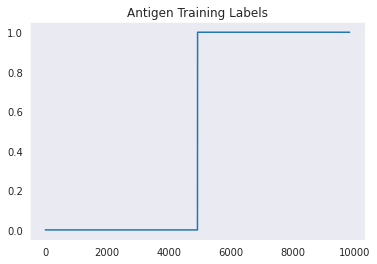

In [ ]:
plt.plot(Y.numpy())
plt.title("Antigen Training Labels")
plt.show()

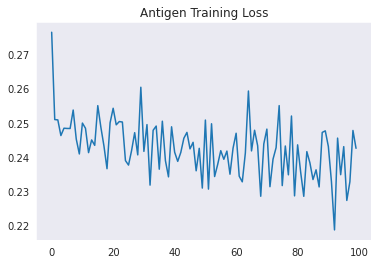

In [ ]:
plt.plot(training_history)
plt.title("Antigen Training Loss")
plt.show()

In [ ]:
filtered_dataset_X = ACC(filtered_df['Sequence'].values)
antigens = torch.tensor(filtered_dataset_X)

counter   = antigens.shape[1] - 1
X         = antigens[:,:counter]        # Protein ACC
Y         = antigens[:,45:]             # Whether it's BPA

Amodel.eval()
Y_pred = Amodel(X)
Y_pred_bin = (Y_pred > 0.6).int()

X.shape, Y_pred.shape

(torch.Size([698, 45]), torch.Size([698, 1]))

Ignore the 0s, 1 is Antigen Candidate


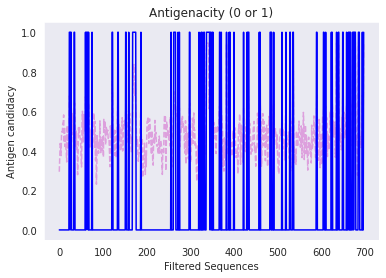

In [ ]:
print("Ignore the 0s, 1 is Antigen Candidate")

Y_pred = Y_pred.detach().numpy()
Y_pred_bin = Y_pred_bin.detach().numpy()

plt.plot(Y_pred, '--', color="plum")
plt.plot(Y_pred_bin, color="blue")
plt.title("Antigenacity (0 or 1)")
plt.xlabel('Filtered Sequences')
plt.ylabel('Antigen candidacy')
plt.show()

In [ ]:
sequence_r = X[19]
sequence_r

tensor([-1.9066, -1.3528, -0.2916, -0.1630, -0.6482, -2.2513, -2.5737, -3.7339,
        -3.2947, -2.9703, -2.5804, -0.3291,  0.4509, -0.5815, -1.0075, -1.6167,
        -2.9160, -2.4264, -2.9518, -1.1726, -0.3766, -0.2238, -0.6678, -2.2190,
        -2.9076, -4.3329, -3.8728, -2.5183, -1.6092, -0.4188, -2.4855, -0.6546,
        -2.3639, -3.1538, -4.6643, -4.4938, -1.2092, -1.8700, -0.3091, -2.7861,
        -0.4870, -1.9755, -2.8307, -3.4680, -3.1359])

In [ ]:
# Amodel

Sequential(
  (0): Lambda()
  (1): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (2): ReLU()
  (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (4): ReLU()
  (5): Conv2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (6): ReLU()
  (7): AvgPool2d(kernel_size=(6, 1), stride=(6, 1), padding=0)
  (8): Lambda()
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  # Remove the CWD from sys.path while we load stuff.


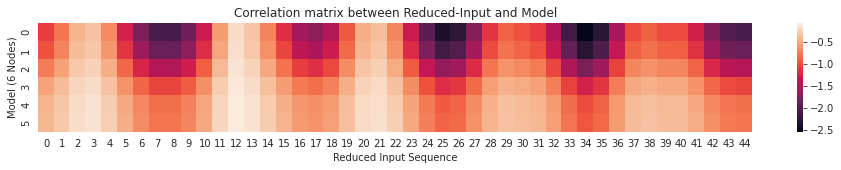

In [ ]:
# attention_layer = 6
# input = torch.tensor( sequence_r )
# fig, ax = plt.subplots(figsize = (16, 2))

# for layer_num in range(attention_layer):
#     layer = Amodel[layer_num]
#     input = layer(input)

# data = input.detach().numpy().reshape(input.shape[-2:])
# data = input @ torch.tensor( [ np.array(sequence_r) ] )
# data = data.reshape( data.shape[-2:] )
# data = data.detach().numpy()

# # Smoothing
# from scipy.ndimage.filters import gaussian_filter
# data_smooth = gaussian_filter(data, sigma=1)


# # Plot
# ax = sns.heatmap(data_smooth)
# ax.set_xlabel('Reduced Input Sequence')
# ax.set_ylabel('Model (6 Nodes)')

# plt.title("Correlation matrix between Reduced-Input and Model")
# plt.show()

### Custom Model

In [26]:
import tensorflow as tf

In [27]:
bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))
d_1 = tf.keras.layers.Dense(32, )
d_2 = tf.keras.layers.Dense(16, activation='relu')
d_3 = tf.keras.layers.Dense(3, )
d_4 = tf.keras.layers.Dense(1, activation='sigmoid')

model = tf.keras.Sequential([
    bi_lstm,
    d_1,
    d_2,
    d_3,
    d_4
])

In [28]:
import numpy as np

In [29]:
def avg(iter_loss):
    return sum(iter_loss) / len(iter_loss) if len(iter_loss) != 0 else 1

21
21
21
21


In [30]:
def ReadTxtName(rootdir):
    lines = []
    with open(rootdir, 'r') as file_to_read:
        while True:
            line = file_to_read.readline()
            if not line:
                break
            line = line.strip('\n')
            lines.append(line)
    return lines

In [33]:
from sklearn.model_selection import train_test_split
## Read the dataset

datasetB_P  = ReadTxtName(r'./Sample_Pos.txt')
datasetB_N  = ReadTxtName(r'./Sample_Neg.txt')

## Protein annotation:
datasetB_P = encode(datasetB_P)
datasetB_N = encode(datasetB_N)

X = np.array( [ *datasetB_P, *datasetB_N ] )
Y = np.array( [ *np.ones(len(datasetB_P)), *np.zeros(len(datasetB_N)) ] )



Y = Y.reshape( [ *Y.shape, 1 ])
print(len(datasetB_P))

import sklearn.model_selection as sk

train_X, test_X, train_y, test_y = sk.train_test_split(X, Y, test_size=0.20, random_state = 0)

train_X, train_y = X, Y

#train_y.shape
X.shape
X.shape, Y.shape
test_X.shape
print(len(datasetB_P))

125
125


In [34]:
##Define FASTA reader and TXT reader
def read_from_file_with_enter(filename):
    fr = open(filename,'r')
    sample = ""
    samples = []
    for line in fr:
        if line.startswith('>'):
            sample = ""
            continue
        if line.startswith('\n'):
            samples.append(sample)
            continue
        sample += line[:-1]
    return samples

def ReadTxtName(rootdir):
    lines = []
    with open(rootdir, 'r') as file_to_read:
        while True:
            line = file_to_read.readline()
            if not line:
                break
            line = line.strip('\n')
            lines.append(line)
    return lines

In [ ]:


##Prepare B-cell Epitope dataset:


0
24
21
21


Deep learning sequential model with Relu activation

In [35]:
def get_model(in_size):
    return nn.Sequential(
            nn.Linear(in_size, 90),
            nn.Tanh(),
            nn.Linear(90, 60),
            nn.Tanh(),
            nn.Linear(60, 20),
            nn.Tanh(),
            nn.Linear(20, 1),
            nn.ReLU()
        )

def Antigens(antigens, num_epochs=9000, batch_size=128, model=None, lrate=0.001):

    counter   = antigens.shape[1]
    X         = antigens[:,:counter]        #Protein ACC
    Y         = antigens[:,14:]             #Whether it's BPA


    if not model:
        model = get_model(X.shape[1])

    opt   = optim.Adam(model.parameters(), lr=lrate)
    td    = TensorDataset(X, Y)
    epoch = 0

    while epoch < num_epochs:
        for x, y in DataLoader(td, batch_size, shuffle=True, drop_last=True):
            opt.zero_grad()
            result = model(x)
            loss   = ((result - y)**2).mean()
            #loss   = nn.CrossEntropyLoss(result, y).mean()
            #loss   = torch.mean(torch.clamp(1 - result.t() * y, min=0))  # hinge loss
            #loss  += 0.01 * torch.mean(model.weight ** 2)  # l2 penalty
            loss.backward()
            opt.step()

        epoch += 1

        print(loss)
    return model

In [ ]:
#Complile the model and then prediction

In [61]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-2),
    metrics=['accuracy']
)

In [44]:
predictions = model.predict(train_X)
#predictions = model.predict(indices_train)
print(predictions[0], predictions.shape)

8/8 [==============================] - 1s 5ms/step
[0.35115367] (250, 1)


8/8 [==============================] - 1s 6ms/step
[0.35115367] (250, 1)


In [54]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-2),
    metrics=['accuracy']
)

In [43]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-2),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.AUC(from_logits=True)])

Adam removed (1e-2)

Save the model

In [ ]:
torch.save(model, 'pL2quickmodel.pkl')

/content/pL2quickmodel.pkl

In [ ]:
model.compile(optimizer="adam", loss="mean_squared_error")

In [ ]:
train_X.shape, train_y.shape

((250, 10, 3), (250, 1))

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


8/8 [==============================] - 5s 12ms/step - loss: -72.5720 - accuracy: 0.3600


In [62]:
history = model.fit(train_X, train_y, epochs=100,
                    validation_data=(test_X, test_y))

Epoch 1/100
8/8 [==============================] - 6s 204ms/step - loss: 1.8110e-09 - accuracy: 1.0000 - val_loss: 1.6620e-09 - val_accuracy: 1.0000
Epoch 2/100
8/8 [==============================] - 0s 22ms/step - loss: 1.8119e-09 - accuracy: 1.0000 - val_loss: 1.6624e-09 - val_accuracy: 1.0000
Epoch 3/100
8/8 [==============================] - 0s 22ms/step - loss: 1.8133e-09 - accuracy: 1.0000 - val_loss: 1.6632e-09 - val_accuracy: 1.0000
Epoch 4/100
8/8 [==============================] - 0s 26ms/step - loss: 1.8146e-09 - accuracy: 1.0000 - val_loss: 1.6636e-09 - val_accuracy: 1.0000
Epoch 5/100
8/8 [==============================] - 0s 23ms/step - loss: 1.8162e-09 - accuracy: 1.0000 - val_loss: 1.6645e-09 - val_accuracy: 1.0000
Epoch 6/100
8/8 [==============================] - 0s 23ms/step - loss: 1.8186e-09 - accuracy: 1.0000 - val_loss: 1.6653e-09 - val_accuracy: 1.0000
Epoch 7/100
8/8 [==============================] - 0s 25ms/step - loss: 1.8201e-09 - accuracy: 1.0000 - val_los

In [ ]:
torch.save(model, 'pL23quickmodel.pkl')

In [46]:
history = model.fit(train_X, train_y, batch_size=90, epochs=1250, validation_data=(test_X, test_y))

Epoch 1/1250
3/3 [==============================] - 0s 56ms/step - loss: 9.3558e-06 - auc: 1.0000 - val_loss: 1.1969e-05 - val_auc: 1.0000
Epoch 2/1250
3/3 [==============================] - 0s 34ms/step - loss: 9.2929e-06 - auc: 1.0000 - val_loss: 1.1892e-05 - val_auc: 1.0000
Epoch 3/1250
3/3 [==============================] - 0s 38ms/step - loss: 9.2271e-06 - auc: 1.0000 - val_loss: 1.1815e-05 - val_auc: 1.0000
Epoch 4/1250
3/3 [==============================] - 0s 28ms/step - loss: 9.1617e-06 - auc: 1.0000 - val_loss: 1.1740e-05 - val_auc: 1.0000
Epoch 5/1250
3/3 [==============================] - 0s 47ms/step - loss: 9.1007e-06 - auc: 1.0000 - val_loss: 1.1661e-05 - val_auc: 1.0000
Epoch 6/1250
3/3 [==============================] - 0s 53ms/step - loss: 9.0354e-06 - auc: 1.0000 - val_loss: 1.1585e-05 - val_auc: 1.0000
Epoch 7/1250
3/3 [==============================] - 0s 45ms/step - loss: 8.9747e-06 - auc: 1.0000 - val_loss: 1.1509e-05 - val_auc: 1.0000
Epoch 8/1250
3/3 [=========

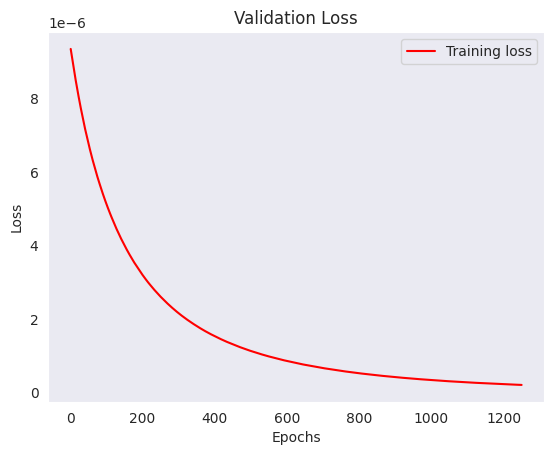

In [47]:
%matplotlib inline
history_dict = history.history
history_dict.keys()

loss = history_dict['loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'r-', label='Training loss')

plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
fitted1 = model.fit(train_X, train_y, batch_size=90, epochs=125, validation_data=(test_X, test_y))

Epoch 1/125


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


3/3 [==============================] - 6s 508ms/step - loss: 0.6894 - accuracy: 0.5760 - val_loss: 0.5770 - val_accuracy: 0.7800
Epoch 2/125
3/3 [==============================] - 0s 31ms/step - loss: 0.5807 - accuracy: 0.7080 - val_loss: 0.4965 - val_accuracy: 0.8200
Epoch 3/125
3/3 [==============================] - 0s 37ms/step - loss: 0.4868 - accuracy: 0.8040 - val_loss: 0.4118 - val_accuracy: 0.8600
Epoch 4/125
3/3 [==============================] - 0s 37ms/step - loss: 0.4092 - accuracy: 0.8400 - val_loss: 0.3524 - val_accuracy: 0.8400
Epoch 5/125
3/3 [==============================] - 0s 32ms/step - loss: 0.3575 - accuracy: 0.8440 - val_loss: 0.2878 - val_accuracy: 0.9200
Epoch 6/125
3/3 [==============================] - 0s 37ms/step - loss: 0.2979 - accuracy: 0.9040 - val_loss: 0.2541 - val_accuracy: 0.9000
Epoch 7/125
3/3 [==============================] - 0s 39ms/step - loss: 0.2590 - accuracy: 0.9120 - val_loss: 0.2208 - val_accuracy: 0.8400
Epoch 8/125
3/3 [==============

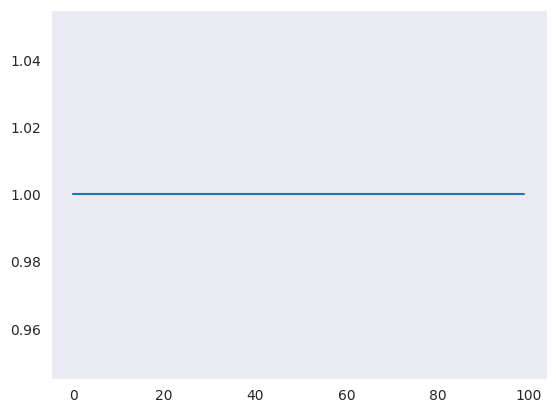

In [63]:
from matplotlib import pyplot
pyplot.plot(history.history['accuracy'])
pyplot.show()

In [56]:
#np.average(test_y - model.predict(test_X))

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

pred = model.predict(test_X) > 0.359
#pred = model.predict(test_y) > 0.75
truth = test_y

# diff = np.abs(truth - (pred > 0.3))

# np.unique(diff, return_counts=True)

threshold = 0.459
#print(accuracy_score((test_y, y_pred)))
accuracy_score(pred > threshold, truth), precision_score(pred, truth), recall_score(pred > threshold, truth), \
f1_score(pred > threshold, truth), roc_auc_score(pred > threshold, truth),



2/2 [==============================] - 1s 7ms/step


(1.0, 1.0, 1.0, 1.0, 1.0)

In [50]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'auc', 'val_loss', 'val_auc'])

In [ ]:
print(history.history['accuracy'])

[0.6639999747276306, 0.8119999766349792, 0.8679999709129333, 0.8960000276565552, 0.8920000195503235, 0.9079999923706055, 0.9279999732971191, 0.9399999976158142, 0.9520000219345093, 0.9639999866485596, 0.9279999732971191, 0.9279999732971191, 0.9679999947547913, 0.9879999756813049, 0.9959999918937683, 0.9959999918937683, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


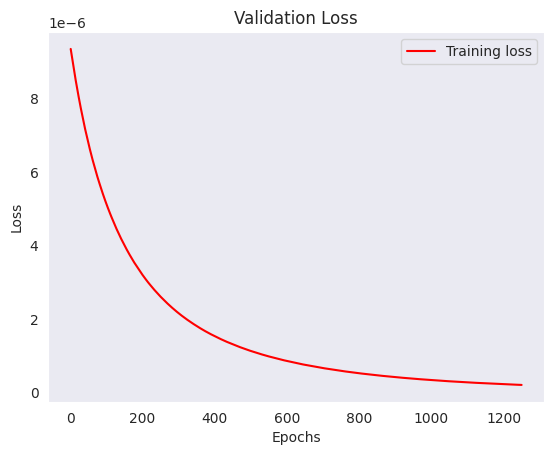

In [51]:
%matplotlib inline


loss = history_dict['loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'r-', label='Training loss')

plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [64]:
%matplotlib inline
# works

acc = history_dict['accuracy']
#acc = history_dict['auc']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training Accuracy')

plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

KeyError: 'accuracy'

In [ ]:
# plt.style.available

TypeError: dict.values() takes no arguments (1 given)

In [65]:
#Amodel = load_model(model, compile= True)
filtered_dataset_X = encode(filtered_df['Sequence'].values)
antigens = np.array(filtered_dataset_X)

#samples_to_predict = np.array(antigens)
predictions = model.predict(antigens)
print(predictions)
print(antigens[0])
print(antigens)

Y_pred = model.predict(antigens)
Y_pred_P = (Y_pred > 0.759)
#print(Y_pred_P)
print(accuracy_score,(test_y, Y_pred))
#print(Y_pred_P)


22/22 [==============================] - 1s 4ms/step
[[3.16203398e-07]
 [2.14602125e-07]
 [1.86660481e-14]
 [1.38996457e-20]
 [3.01137222e-19]
 [3.22861599e-24]
 [1.33333730e-12]
 [1.42951363e-11]
 [1.83684856e-11]
 [2.33482069e-06]
 [8.23256185e-11]
 [1.00000000e+00]
 [2.60646343e-19]
 [1.52251590e-23]
 [1.46517354e-14]
 [6.06040704e-11]
 [1.00000000e+00]
 [9.99864101e-01]
 [9.55765247e-01]
 [1.49684751e-17]
 [2.94924320e-19]
 [2.48026481e-26]
 [2.58890940e-15]
 [1.00000000e+00]
 [3.52117837e-07]
 [3.91348169e-19]
 [3.38524520e-09]
 [1.39517908e-08]
 [2.50563589e-12]
 [1.73935419e-20]
 [1.93501689e-19]
 [9.93573353e-17]
 [1.32660024e-15]
 [6.88205894e-13]
 [1.00000000e+00]
 [1.53357691e-11]
 [3.12115203e-16]
 [2.99200332e-23]
 [2.41407795e-22]
 [1.97565512e-16]
 [2.18986340e-17]
 [4.63897675e-01]
 [1.37538865e-01]
 [3.19428305e-04]
 [3.42005023e-07]
 [1.41290781e-11]
 [3.15588562e-11]
 [1.96717620e-12]
 [1.34201461e-12]
 [9.99998808e-01]
 [9.99994755e-01]
 [4.46473956e-01]
 [9.9999910

In [66]:
filtered_dataset_X = encode(filtered_df['Sequence'].values)
antigens = np.array(filtered_dataset_X)


Y_pred = model.predict(antigens)
Y_pred_P = (Y_pred > 0.759)

#RocCurveDisplay(Y_pred,Y_pred_P)

22/22 [==============================] - 0s 3ms/step


In [67]:
from sklearn import metrics
from sklearn.metrics import classification_report
print(accuracy_score,(test_y,Y_pred))
#print('Recall: ',metrics.recall_score(test_y, Y_pred, zero_division=1))
print('Precision:',metrics.precision_score(test_y, Y_pred, zero_division=1))
print('CL Report:',metrics.classification_report(test_y, Y_pred, zero_division=1))

<function accuracy_score at 0x7eadb1ab51b0> (array([[0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.]]), array([[3.16203398e-07],
       [2.14602125e-07],
       [1.86660481e-14],
       [1.38996457e-20],
       [3.01137222e-19],
       [3.22861599e-24],
       [1.33333730e-12],
       [1.42951363e-11],
       [1.83684856e-11],
       [2.33482069e-06],
       [8.23256185e-11],
       [1.00000000e+00],
   

ValueError: Found input variables with inconsistent numbers of samples: [50, 698]

Ignore the 0s, 1 is Antigen Candidate


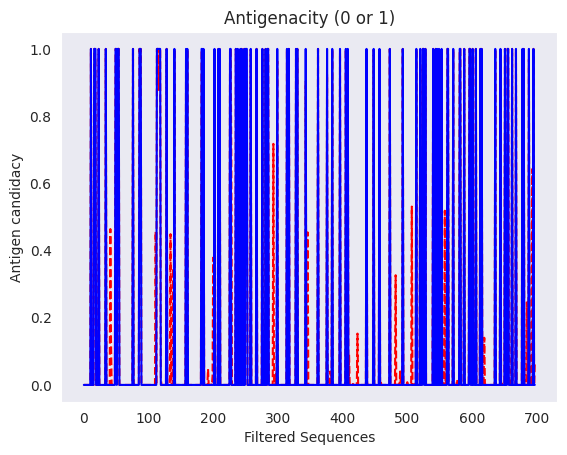

In [68]:
print("Ignore the 0s, 1 is Antigen Candidate")

plt.plot(Y_pred, '--', color="red")
plt.plot(Y_pred_P, color="blue")
plt.title("Antigenacity (0 or 1)")
plt.xlabel('Filtered Sequences')
plt.ylabel('Antigen candidacy')
plt.show()

In [ ]:
###predicting values

In [69]:
threshold=0.459
predicted_class1=np.zeros(Y_pred_P.shape)
predicted_class1[predictions>threshold]=1
predicted_class1
print(predicted_class1)

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.

In [70]:
threshold=0.47

predicted_class2=np.zeros(Y_pred_P.shape)
predicted_class2[predictions>threshold]=0
predicted_class2

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],

In [71]:
threshold=0.47

predicted_class2=np.zeros(Y_pred_P.shape)
predicted_class2[Y_pred_P>threshold]=0
predicted_class2

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],

In [72]:
#Confusion matrix, Accuracy, sensitivity and specificity
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix

cm1 = confusion_matrix(Y_pred_P,predicted_class1)
print('Confusion Matrix : \n', cm1)

#plt.title(title)


total1=sum(sum(cm1))
#####from confusion matrix calculate accuracy
accuracy1=(cm1[0,0]+cm1[1,1])/total1
print ('Accuracy : ', accuracy1)

sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print('Specificity : ', specificity1)

Confusion Matrix : 
 [[589  12]
 [  0  97]]
Accuracy :  0.9828080229226361
Sensitivity :  0.9800332778702163
Specificity :  1.0


Text(50.722222222222214, 0.5, 'Actual')

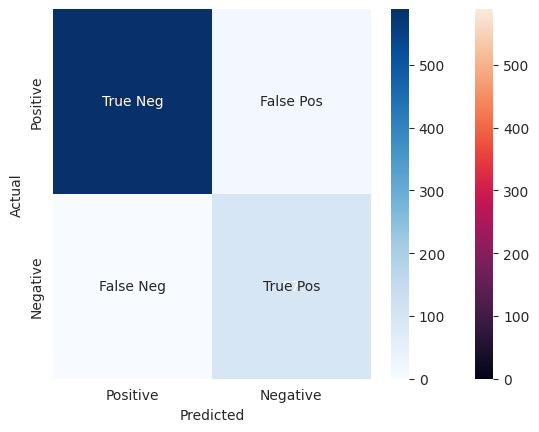

In [73]:
import pandas as pd
cm1 = confusion_matrix(Y_pred_P,predicted_class1)
cm2 = confusion_matrix(Y_pred_P,predicted_class2)
import seaborn as sns
sns.heatmap(cm1, annot=True)
labels = ['True Neg','False Pos','False Neg','True Pos']
labels = np.asarray(labels).reshape(2,2)
classes =['Positive', 'Negative']
sns.heatmap(cm1, annot=labels, fmt='', cmap='Blues',xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')

Text(50.722222222222214, 0.5, 'Predicted')

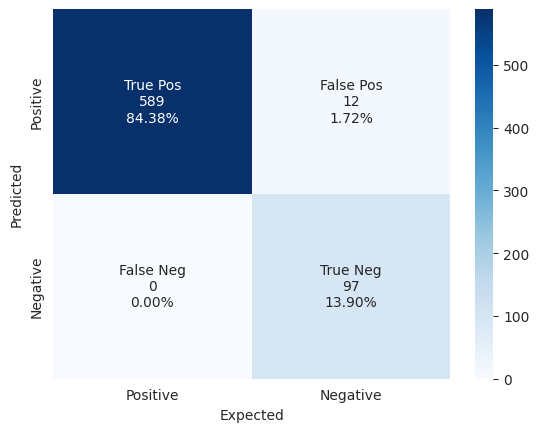

In [74]:
group_names = ['True Pos','False Pos','False Neg','True Neg']
group_counts = ['{0:0.0f}'.format(value) for value in
                cm1.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cm1.flatten()/np.sum(cm1
                                          )]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm1, annot=labels, fmt='', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Expected')
plt.ylabel('Predicted')

In [ ]:
filtered_dataset_X = encode(filtered_df['Sequence'].values)
antigens = np.array(filtered_dataset_X)


Y_pred = model.predict(antigens)
Y_pred_P = (Y_pred > 0.6)
print(Y_pred_P)
#RocCurveDisplay(Y_pred,Y_pred_P)

22/22 [==============================] - 0s 7ms/step
[[False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [ True]
 [False]
 [ True]
 [False]
 [False]
 [False]
 [False]
 [ True]
 [ True]
 [ True]
 [False]
 [False]
 [False]
 [False]
 [ True]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [ True]
 [ True]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [ True]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [ True]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [ True]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [ True]
 [ True]
 [ True]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [

In [ ]:
cf_matrix = confusion_matrix(Y_pred, Y_pred_P)
print(cf_matrix)

In [75]:
# new pasted
print("antigens=%s, Predicted=%s" %(antigens[0], Y_pred_P[0]))

antigens=[[ 2.88  2.52 -3.44]
 [-2.49 -0.27 -0.41]
 [ 0.07 -1.73  0.09]
 [-4.44 -1.68 -1.03]
 [-4.19 -1.03 -0.98]
 [ 2.23 -5.36  0.3 ]
 [ 3.64  1.13  2.36]
 [ 0.92 -2.09 -1.4 ]
 [ 0.07 -1.73  0.09]
 [-4.75  3.65  0.85]], Predicted=[False]


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-2),
    metrics=[keras.metrics.AUC(from_logits=True)])

NameError: name 'model' is not defined

In [ ]:
history = model.fit(train_X, train_y, batch_size=90, epochs=1250, validation_data=(test_X, test_y))

In [76]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

pred = model.predict(antigens) > 0.2
#pred = model.predict(train_X) > 0.5
truth = test_y

# diff = np.abs(truth - (pred > 0.3))

# np.unique(diff, return_counts=True)

threshold = 0.25

accuracy_score(pred > threshold, truth), precision_score(pred, truth), recall_score(pred > threshold, truth), \
f1_score(pred > threshold, truth), roc_auc_score(pred > threshold, truth)

22/22 [==============================] - 0s 4ms/step


ValueError: Found input variables with inconsistent numbers of samples: [698, 50]

In [ ]:
!pip install matplotlib-venn
#sk.metrics.plot_confusion_matrix
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
#from sklearn.metrics import confusion_matrix, plot_confusion_matrix



fig, ax = plot_confusion_matrix(model, test_X, test_y)
#ConfusionMatrixDisplay(cm, test_X, test_y)
#plot_ConfusionMatrixDisplay(model, test_X, test_y)

ImportError: cannot import name 'plot_confusion_matrix' from 'sklearn.metrics' (/usr/local/lib/python3.10/dist-packages/sklearn/metrics/__init__.py)

In [ ]:
from sklearn import metrics
Y_pred = model.predict(antigens)
Y_pred =(Y_pred>0.25)
list(Y_pred)
confusion_matrix = metrics.cm1(test_X,Y_pred)
#cm = confusion_matrix(test_y, y_pred)
print(confusion_matrix)


22/22 [==============================] - 0s 4ms/step


AttributeError: module 'sklearn.metrics' has no attribute 'cm1'

2/2 [==============================] - 0s 12ms/step


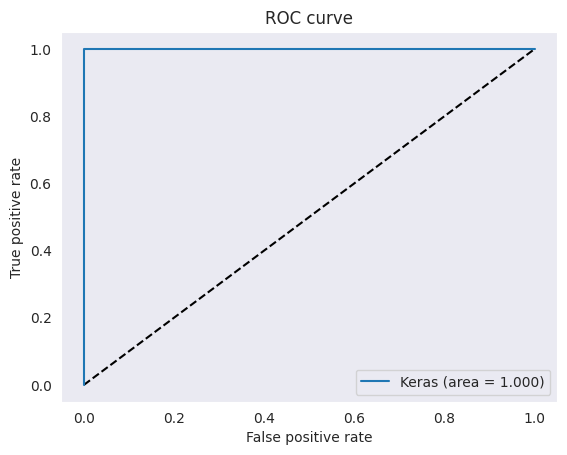

In [77]:
from sklearn.metrics import roc_curve
y_pred_keras = model.predict(test_X).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_y, y_pred_keras)
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)
#

y_pred_keras = model.predict(test_X).ravel()
fpr, tpr, thresholds = roc_curve(test_y, y_pred_keras)



plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

ModuleNotFoundError: No module named 'scikeras'

Ignore the 0s, 1 is Antigen Candidate


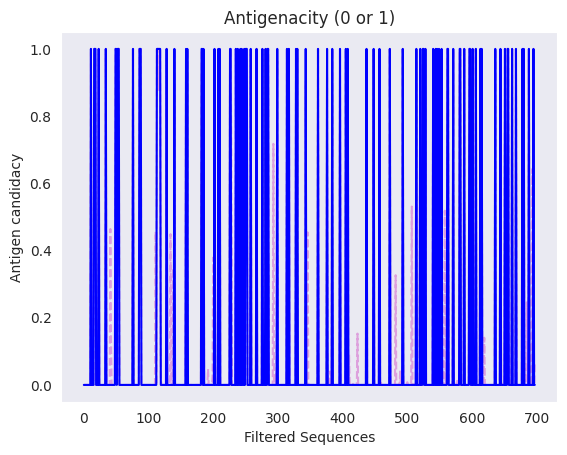

In [78]:
# new pasted
print("Ignore the 0s, 1 is Antigen Candidate")

plt.plot(Y_pred, '--', color="plum")
plt.plot(Y_pred_P, color="blue")
plt.title("Antigenacity (0 or 1)")
plt.xlabel('Filtered Sequences')
plt.ylabel('Antigen candidacy')
plt.show()

Ignore the 0s, 1 is Antigen Candidate


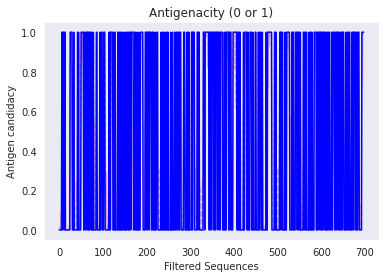

In [ ]:
print("Ignore the 0s, 1 is Antigen Candidate")

plt.plot(Y_pred, '--', color="plum")
plt.plot(Y_pred_P, color="blue")
plt.title("Antigenacity (0 or 1)")
plt.xlabel('Filtered Sequences')
plt.ylabel('Antigen candidacy')
plt.show()

In [79]:
Y_pred.shape

(698, 1)

In [80]:
filtered_df['antigenicity'] = Y_pred

<ipython-input-80-37c694635a9c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['antigenicity'] = Y_pred


In [ ]:
filtered_df.head()

,Sequence,Repeation,Seen In,antigenicity
124,RMAILGDTAW,6008,"DENGUE VIRUS 2, DENGUE VIRUS 4, DENGUE VIRUS 1...",0.000516
125,MAILGDTAWD,6025,"DENGUE VIRUS 2, DENGUE VIRUS 4, DENGUE VIRUS 1...",0.010988
126,AILGDTAWDF,6031,"DENGUE VIRUS 2, DENGUE VIRUS 4, DENGUE VIRUS 1...",0.000123
127,ILGDTAWDFG,6063,"DENGUE VIRUS 2, DENGUE VIRUS 4, DENGUE VIRUS 1...",0.000240
128,LGDTAWDFGS,6077,"DENGUE VIRUS 2, DENGUE VIRUS 4, DENGUE VIRUS 1...",0.086677


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
filtered_df.to_csv("[filtered][prediction]100% seq chunk-10.csv", index=False, )

In [81]:
model_plotting = tf.keras.Sequential([
    bi_lstm,
    d_1,
    d_2,
    d_3
])

plot_pred = model_plotting.predict(antigens)

plot_pred[0:2]

22/22 [==============================] - 1s 3ms/step


array([[-2.68224  , -7.1504755,  2.9992402],
       [-1.9616058, -7.594732 ,  4.5874844]], dtype=float32)

In [82]:
# new pasted
model_plotting = tf.keras.Sequential([
    bi_lstm,
    d_1,
    d_2,
    d_3
])

plot_pred = model_plotting.predict(antigens)

plot_pred[0:2]

22/22 [==============================] - 1s 3ms/step


array([[-2.68224  , -7.1504755,  2.9992402],
       [-1.9616058, -7.594732 ,  4.5874844]], dtype=float32)

In [83]:
from matplotlib import cm
cmap_d = cm._gen_cmap_d()

print(cmap_d.keys())

AttributeError: module 'matplotlib.cm' has no attribute '_gen_cmap_d'

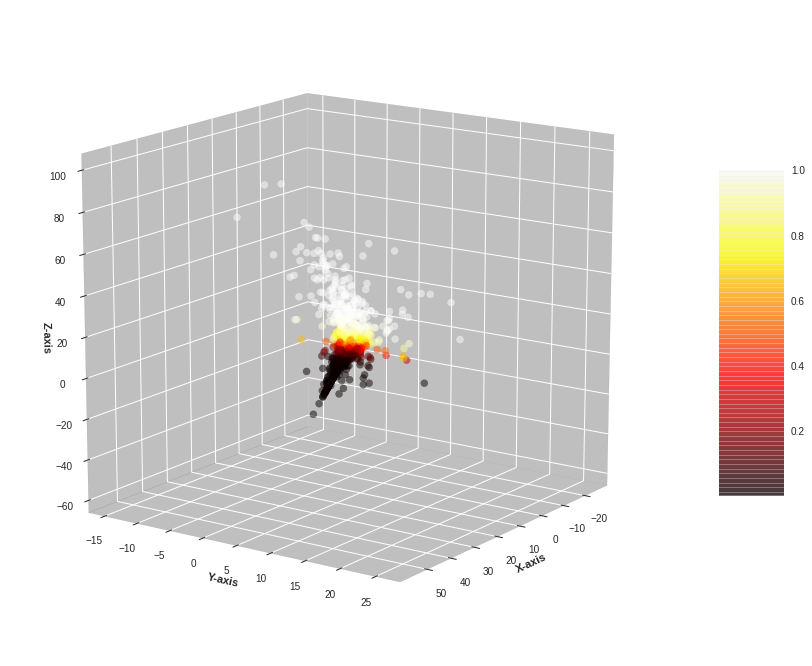

In [ ]:
import matplotlib as mpl
x, y, z = plot_pred[:, 0], plot_pred[:, 1], plot_pred[:, 2]

# Black Style
# plt.style.use('dark_background')
plt.style.use('seaborn')

# Creating figure
fig = plt.figure(figsize = (15, 12))
ax = plt.axes(projection ="3d")


fig.patch.set_facecolor('white')
fig.patch.set_alpha(0.0)

ax.patch.set_facecolor('white')
ax.patch.set_alpha(0.0)

color = (0.5, 0.5, 0.5, 0.5)

ax.w_xaxis.set_pane_color(color)
ax.w_yaxis.set_pane_color(color)
ax.w_zaxis.set_pane_color(color)

# Creating color map
my_cmap = cmap_d['hot']
# my_cmap = cmap_d['afmhot']
# my_cmap = cmap_d['Spectral']
# my_cmap = cmap_d['coolwarm']


# Creating plot
scat = ax.scatter3D(x, y, z, c=Y_pred, alpha = 0.5, s=50, cmap=my_cmap)

ax.set_xlabel('X-axis', fontweight ='bold')
ax.set_ylabel('Y-axis', fontweight ='bold')
ax.set_zlabel('Z-axis', fontweight ='bold')
ax.view_init(15, 35)
fig.colorbar(scat, ax = ax, shrink = 0.5, aspect = 5)

# show plot
plt.show()

In [ ]:
from sklearn.metrics import auc, roc_auc_score

roc_auc_score(train_X[test_y], Y_pred)
fpr, tpr, _ = roc_curve(train_X[test_y], y_pred) # to plot curve

precision, recall, thresholds = precision_recall_curve(train_X[test_y], Y_pred)
auc(recall, precision)

IndexError: arrays used as indices must be of integer (or boolean) type

<ipython-input-75-1dc1192ba9a6>:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')
<ipython-input-75-1dc1192ba9a6>:22: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax.w_xaxis.set_pane_color(color)
<ipython-input-75-1dc1192ba9a6>:23: MatplotlibDeprecationWarning: The w_yaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use yaxis instead.
  ax.w_yaxis.set_pane_color(color)
<ipython-input-75-1dc1192ba9a6>:24: MatplotlibDeprecationWarning: The w_zaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use zaxis instead.
  ax.w_zaxis.set_pane_color(color)


NameError: name 'cmap_d' is not defined

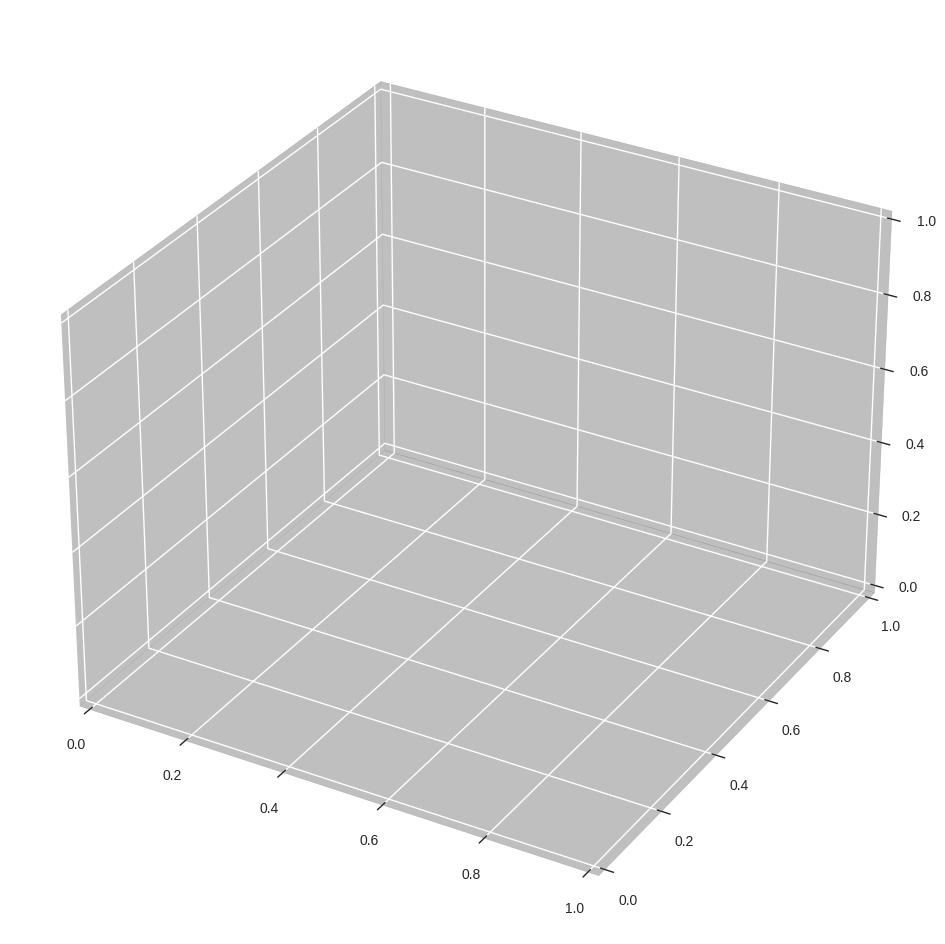

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
x, y, z = plot_pred[:, 0], plot_pred[:, 1], plot_pred[:, 2]

# Black Style
# plt.style.use('dark_background')
plt.style.use('seaborn')

# Creating figure
fig = plt.figure(figsize = (15, 12))
ax = plt.axes(projection ="3d")


fig.patch.set_facecolor('white')
fig.patch.set_alpha(0.0)

ax.patch.set_facecolor('white')
ax.patch.set_alpha(0.0)

color = (0.5, 0.5, 0.5, 0.5)

ax.w_xaxis.set_pane_color(color)
ax.w_yaxis.set_pane_color(color)
ax.w_zaxis.set_pane_color(color)

# Creating color map
my_cmap = cmap_d['hot']
# my_cmap = cmap_d['afmhot']
# my_cmap = cmap_d['Spectral']
# my_cmap = cmap_d['coolwarm']


# Creating plot
scat = ax.scatter3D(x, y, z, c=Y_pred, alpha = 0.5, s=50, cmap=my_cmap)

ax.set_xlabel('X-axis', fontweight ='bold')
ax.set_ylabel('Y-axis', fontweight ='bold')
ax.set_zlabel('Z-axis', fontweight ='bold')
ax.view_init(15, 35)
fig.colorbar(scat, ax = ax, shrink = 0.5, aspect = 5)

# show plot
plt.show()

In [ ]:
# plt.style.available
cmap_d

NameError: name 'cmap_d' is not defined

NameError: name 'cmap_d' is not defined

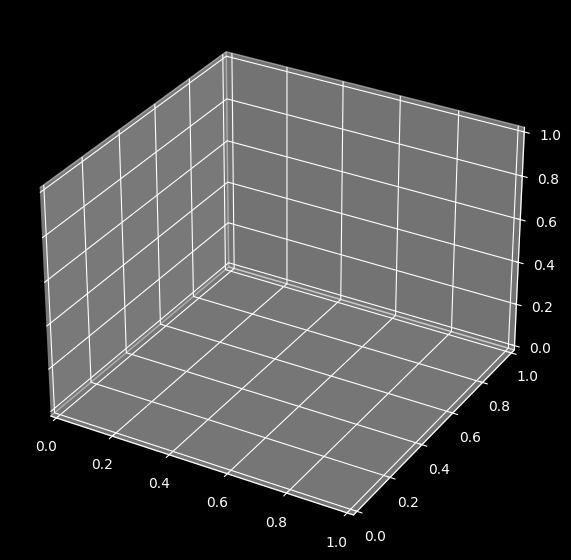

In [ ]:
x, y, z = plot_pred[:, 0], plot_pred[:, 1], plot_pred[:, 2]

# Black Style
plt.style.use('dark_background')

# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

# Creating color map
my_cmap = cmap_d['hot']
# my_cmap = cmap_d['afmhot']
# my_cmap = cmap_d['Spectral']

# Creating plot
scat = ax.scatter3D(x, y, z, c=Y_pred, alpha = 0.5, s=50, cmap=my_cmap)

ax.set_xlabel('X-axis', fontweight ='bold')
ax.set_ylabel('Y-axis', fontweight ='bold')
ax.set_zlabel('Z-axis', fontweight ='bold')
ax.view_init(15, 45)
fig.colorbar(scat, ax = ax, shrink = 0.5, aspect = 5)

# show plot
plt.show()

In [ ]:
from matplotlib import animation

def init():
    scat = ax.scatter3D(x, y, z, c=Y_pred, alpha = 0.5, s=50, cmap=my_cmap)
    return fig,

def animate(i):
    ax.view_init(elev=15., azim=i)
    return fig,


# Animate
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=360, interval=20, blit=True)


anim.save('basic_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

CalledProcessError: ignored

In [ ]:
from IPython.display import HTML
from base64 import b64encode

def show_video(video_path, video_width = 600):

  video_file = open(video_path, "r+b").read()

  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""")

show_video('basic_animation.mp4')

FileNotFoundError: [Errno 2] No such file or directory: 'basic_animation.mp4'

In [ ]:
model_attn = tf.keras.Sequential([
    bi_lstm,
    d_1,
    d_2,
    d_3
])

plot_pred = model_attn.predict(antigens)


22/22 [==============================] - 3s 5ms/step


In [ ]:
attn = antigens[0] @ plot_pred[0]

In [ ]:
attn.shape

(10,)

In [ ]:
attn

array([14.77405995,  0.9311666 , -1.74910055,  1.73641835,  2.12816212,
       -5.24170519, -7.05695772,  3.39565922, -1.74910055, -0.61309508])

In [ ]:
def add_margin(ax,x=0.05,y=0.05):
    # This will, by default, add 5% to the x and y margins. You
    # can customise this using the x and y arguments when you call it.

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    xmargin = (xlim[1]-xlim[0])*x
    ymargin = (ylim[1]-ylim[0])*y

    ax.set_xlim(xlim[0]-xmargin,xlim[1]+xmargin)
    ax.set_ylim(ylim[0]-ymargin,ylim[1]+ymargin)

<ipython-input-116-2b9e59ca91c8>:2: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


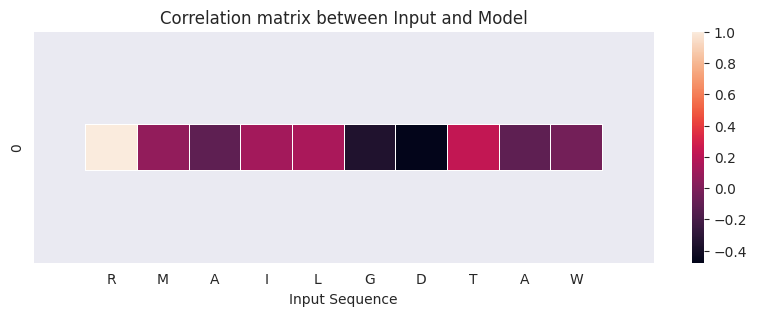

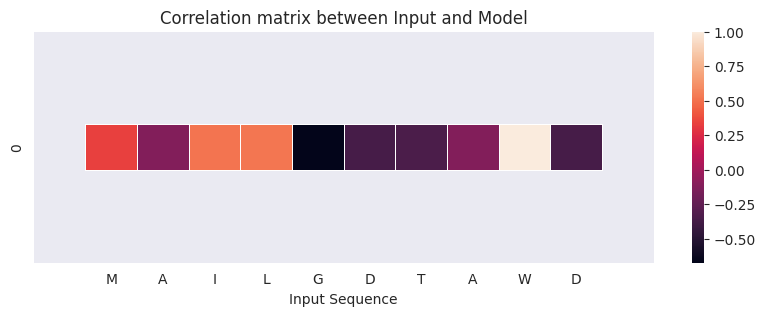

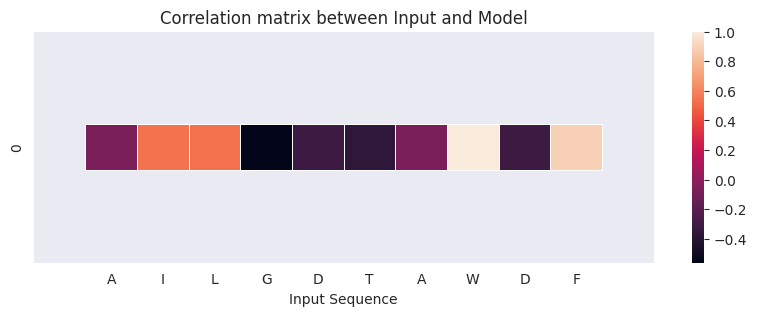

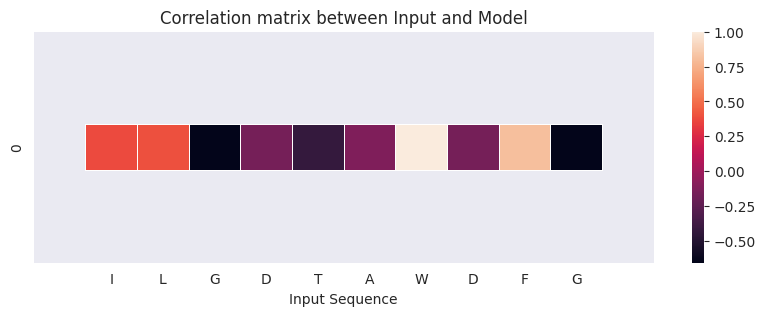

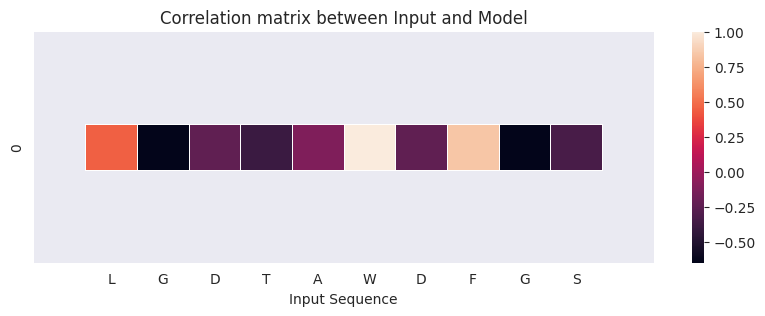

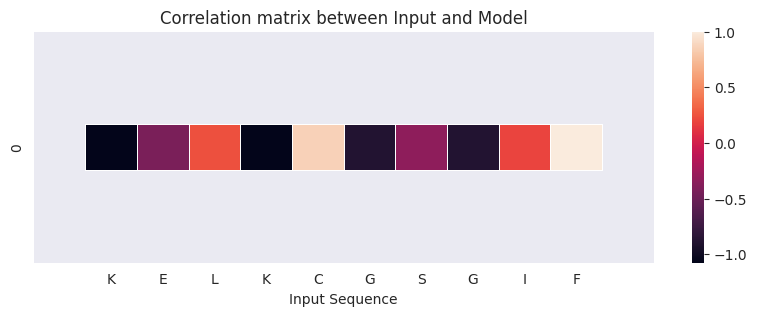

In [ ]:
# Smoothing
from scipy.ndimage.filters import gaussian_filter

def fill_par(x):
    ma = max(x)
    mi = min(x)
    return x / ma

for i in range(0, 6):
    fig, ax = plt.subplots(figsize = (10, 3))

    # Data
    attn = fill_par(antigens[i] @ plot_pred[i])
    data = np.asarray([attn])
    data_smooth = gaussian_filter(data, sigma=1)

    # Plot
    # ax_ = sns.heatmap(data_smooth, linewidths=.5, ax=ax)
    ax_ = sns.heatmap(data, linewidths=.5, ax=ax)
    ax_.set_xlabel('Input Sequence')
    # ax_.set_ylabel('Attention')
    ax_.set_xticklabels(list(unZ(antigens[i])))

    add_margin(ax_, 0.1, 2)

    plt.title("Correlation matrix between Input and Model")

    plt.show()